In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

%matplotlib inline
sns.set('poster')
sns.set_style('whitegrid')

plt.style.use = 'default'
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)

from matplotlib.colors import ListedColormap

- Dealing w/ missing data
- Dealing w/ categorical data
- Feature selection

# Missing data

In [8]:
# create example dataset
from io import StringIO
csv_data = """A,B,C,D
    1.0,2.0,3.0,4.0
    5.0,6.0,,8.0
    10.0,11.0,12.0,"""
df = pd.read_csv(StringIO(csv_data))

In [9]:
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


Identifying nulls

In [10]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

## Eliminate samples or features with missing values
Remove columns, rows entirely

In [11]:
df.dropna()

,A,B,C,D
0,1.0,2.0,3.0,4.0


Drop columns with any NaN

In [12]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


Additional methods

In [13]:
# only drop rows where all columns are NaN
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [20]:
# drop rows that have at least 4 **non-NaN** values
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [26]:
# only drop rows where NaN appear in specific clumns
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


## Imputation

In [27]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN', strategy='mean', axis=0) # axis=0 -> column mean
imr = imr.fit(df)

In [30]:
imputed_data = imr.transform(df)

In [31]:
imputed_data

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   7.5,   8. ],
       [ 10. ,  11. ,  12. ,   6. ]])

**Scikit-learn estimator API**
`fit` & `transform`
- `fit`: learn the params from the traning data
- `transoform`: use the fitted params to transform the data

# Categorical data

In [32]:
df = pd.DataFrame([
        ['green','M',10.1,'class1'],
        ['red','L',13.5,'class2'],
        ['blue','XL',15.3,'class1']])
df.columns = ['color','size','price','classlabel']

In [33]:
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


## Mapping ordinal features

In [36]:
size_mapping = {'XL':3, 'L':2, 'M':1}
df['size'] = df['size'].map(size_mapping)

In [39]:
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [43]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
inv_size_mapping

{1: 'M', 2: 'L', 3: 'XL'}

## Encoding class labels (as int)

In [46]:
class_mapping = {label: idx for idx, label in enumerate(df.classlabel.unique())}
class_mapping

{'class1': 0, 'class2': 1}

In [47]:
df.classlabel = df.classlabel.map(class_mapping)

In [48]:
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [50]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
inv_class_mapping

{0: 'class1', 1: 'class2'}

In [51]:
df.classlabel = df.classlabel.map(inv_class_mapping)

In [52]:
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


Or we can directly use labelencoder from sklearn.

In [54]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values) # input should be an array (not df)
y

array([0, 1, 0])

## One-hot encoding for nominal features
- only works for integers

In [69]:
X = df[['color','size','price']].values
X[:,0] = class_le.fit_transform(X[:,0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [66]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categorical_features=[0]) # [0]: the location of the categorical feature column

In [72]:
ohe.fit_transform(X)

<3x5 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in COOrdinate format>

this is a sparse matrix: good for saving large dataset

In [70]:
ohe.fit_transform(X).toarray()

array([[  0. ,   1. ,   0. ,   1. ,  10.1],
       [  0. ,   0. ,   1. ,   2. ,  13.5],
       [  1. ,   0. ,   0. ,   3. ,  15.3]])

by using numpy, we convert it to dense array representation

**more convenient way: `pd.get_dummies`**

In [74]:
pd.get_dummies(df)

,size,price,color_blue,color_green,color_red,classlabel_class1,classlabel_class2
0,1,10.1,0.0,1.0,0.0,1.0,0.0
1,2,13.5,0.0,0.0,1.0,0.0,1.0
2,3,15.3,1.0,0.0,0.0,1.0,0.0


In [75]:
pd.get_dummies(df,drop_first=True) #  k-1 dummies

,size,price,color_green,color_red,classlabel_class2
0,1,10.1,1.0,0.0,0.0
1,2,13.5,0.0,1.0,1.0
2,3,15.3,0.0,0.0,0.0


# Train-test split
Example dataset: Wine dataset from UCI

In [83]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)
df_wine.columns = ['Class label',
                    'Alcohol', 
                    'Malic acid', 
                    'Ash', 
                    'Alcalinity of ash', 
                    'Magnesium', 
                    'Total phenols', 
                    'Flavanoids', 
                    'Nonflavanoid phenols', 
                    'Proanthocyanins', 
                    'Color intensity', 
                    'Hue',
                    'OD280/OD315 of diluted wines',
                    'Proline'] 

In [85]:
print('Class labels', df_wine['Class label'].unique())

Class labels [1 2 3]


In [86]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [87]:
from sklearn.cross_validation import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

>Instead of discarding the allocated test data after model training and evaluation, it's a good idea to **retrain** a classifier on the **entire dataset** for optimal performance.

# Feature scaling
Why matters: when optimizing objective function, the algo will put more effort into minimizing the error for larger scale values.

**Two approaches**
1. Normalization: rescaling to [0, 1]: (x - x_min) / diff(x_min, x_max)
2. Standardization:  (x - x_mean) / sigma
    - can be more practical because many linear algos initialize the weights as zero or numbers close to zero
    - standardized features are centered around zero, normally distributed, easier to learn

In [88]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

It's important to note that we <span class="mark">fit the scaler only once on the training data</span> and use those parameters to transform the test set. This means this process should exist in the <span class="mark">pipeline.</span>

# Feature selection
One good indicator of overfitting: works much better in training than test

How to fix overfitting
- Collect more data
- Introduce a penalty for complexity via regularization
- Choose a simpler model with fewer parameters
- Reduce the dimensionality of the data

## Sparse solutions with L1 regularization
**Sparse**: with L1 regularization, most feature weights will be zero.

Regularization as geometry
- Regularization can be considered as adding a penalty term to the cost function to encourage smaller weights (= penalize larger weights)
- the point where L2 ball and cost function meets is where the sum of cost and penalty is minimized.
- if this ball become smaller, you are farther away from the point where only cost is minimized meaning, regularization strength is bigger.
- if regularization paremter (lambda) = 0, this means there's no penaly term, which makes it as same as only minimizing the cost function.

**L1 regularization** has a shape of a diamond, which makes this staionary point (where the sum of cost and penalty is minimied) exist on an axis (a weight axis), in which case, the weight becomes zero.

In [89]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Applying to the wine dataset

In [90]:
lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [91]:
print('Training accuracy:', lr.score(X_train_std,y_train))
print('Testing accuracy:', lr.score(X_test_std,y_test))

Training accuracy: 0.983870967742
Testing accuracy: 0.981481481481


Both 98%: do NOT indicate overfitting

In [92]:
lr.intercept_

array([-0.3838773 , -0.15808196, -0.7004204 ])

Remember that this was multiclass classification (3 classes), and it was default (OvR), meaning the first intercept belongs to the model of class 1 vs. (class 2 and 3) and so on.

In [93]:
lr.coef_

array([[ 0.28031914,  0.        ,  0.        , -0.02792089,  0.        ,
         0.        ,  0.71015059,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23590991],
       [-0.64404669, -0.06875095, -0.05723347,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.9267599 ,
         0.06029195,  0.        , -0.37107263],
       [ 0.        ,  0.0615021 ,  0.        ,  0.        ,  0.        ,
         0.        , -0.63609085,  0.        ,  0.        ,  0.49814352,
        -0.35821731, -0.57117062,  0.        ]])

As you can see, a lot of features are sparse.

### Visualize regularization path
regularization path: the weight coefficient of the different features for different regularization strengths

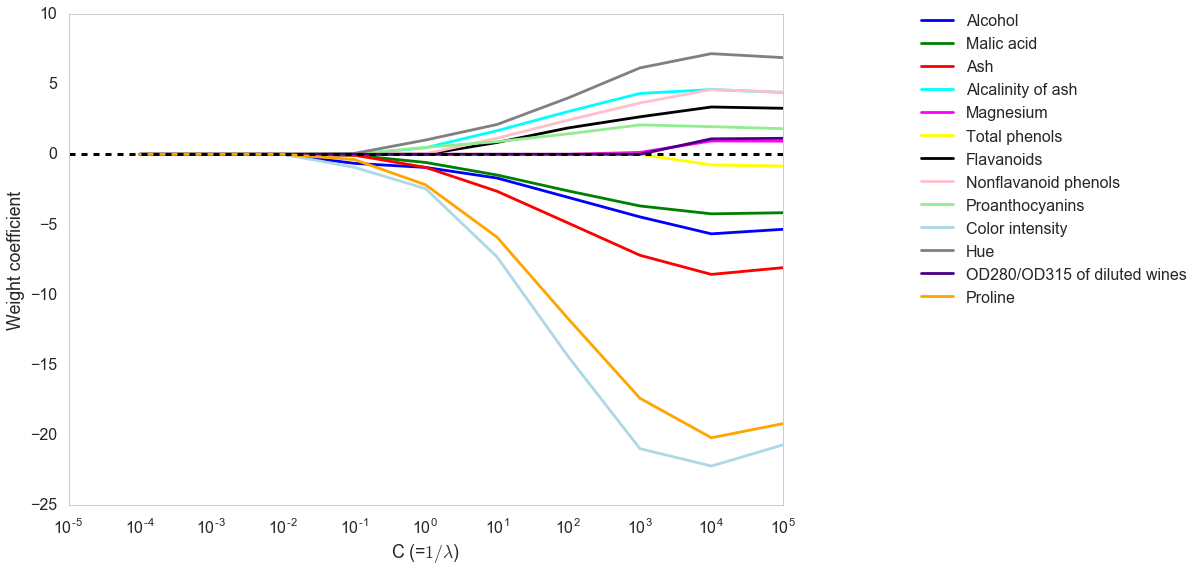

In [110]:
fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue','green','red','cyan','magenta','yellow','black',
          'pink','lightgreen','lightblue','gray','indigo','orange']

weights, params = [], []
for c in np.arange(-4, 6):
    lr = LogisticRegression(penalty='l1', C=10**c, random_state=0)
    lr.fit(X_train_std,y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
    
weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column], label=df_wine.columns[column+1],color=color)
    
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('Weight coefficient')
plt.xlabel('C (=$1 / \lambda $)')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38,1.03), ncol=1, fancybox=True)
plt.show()    

## Sequential feature selection
Dimensionality reduction: useful for algos that **do not support regularization**
1. feature selection
2. feature extraction

**Sequential feature selection**
- Greedy search algo (**NOT exhaustive**: meaning it's a suboptimal solution)
- Reduce dimensions from d to k (d>k)
- Automatically select features that are **most relevant** to improve computational efficiency or reduce the generalization error (by removing irrelevant features)

Example: **sequential backward selection** (SBS)
- Idea: remove irrelevant features from the full feature set until the new feature subspace contains the desired number of features
- Criterion function, *J*, for feature removal
    - J can be a **performance difference between before and after the removal** of a particular feature
- At each stage, we eliminate a feature that causes the least performance loss after removal

Steps of SBS
1. Initialize the feature set (k = d), Xd
2. Determine the feature *x* that maximizes the criterion: x = argmax J(Xk - x)
3. Remove the feature *x* from the feature set
4. Terminate if the k becomes d, if not, go to Step 2.

SBS is not implemented in sklearn. However, sklearn has a similar method called **recursive feature elimination** (RFE).

### SBS implementation

In [135]:
from sklearn.base import clone
from itertools import combinations
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features # the number of features that we want to reduce to
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_] # tuple within a list
        
        # score when we used the whole feature set
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            # for each combination of features "select r features from k features (whole feature set)"
            for p in combinations(self.indices_, r=dim - 1):
                # combinations('ABCD', 2) --> AB AC AD BC BD CD (returns tuples of combinations)
                # combinations(range(4), 3) --> 012 013 023 123
                
                # this will show how scores have changed over iteration
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_) # this will show which features have been selected over iteration
            dim -= 1 # reduce the number of feathre in each iteration

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1] # select the last score

        return self

    def transform(self, X):
        # select a subset of features
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [138]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

Here we **feed training data** although we have train/test split in fit. This <span class="mark">**prevents our original test set becoming part of the training data.**</span>

In [145]:
sbs.subsets_ # progression of feature selection

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 6, 7, 8, 9, 10, 12),
 (0, 1, 2, 3, 6, 7, 8, 10, 12),
 (0, 1, 2, 3, 6, 8, 10, 12),
 (0, 1, 3, 6, 8, 10, 12),
 (0, 1, 3, 6, 10, 12),
 (0, 1, 3, 10, 12),
 (0, 1, 10, 12),
 (0, 1, 10),
 (0, 10),
 (0,)]

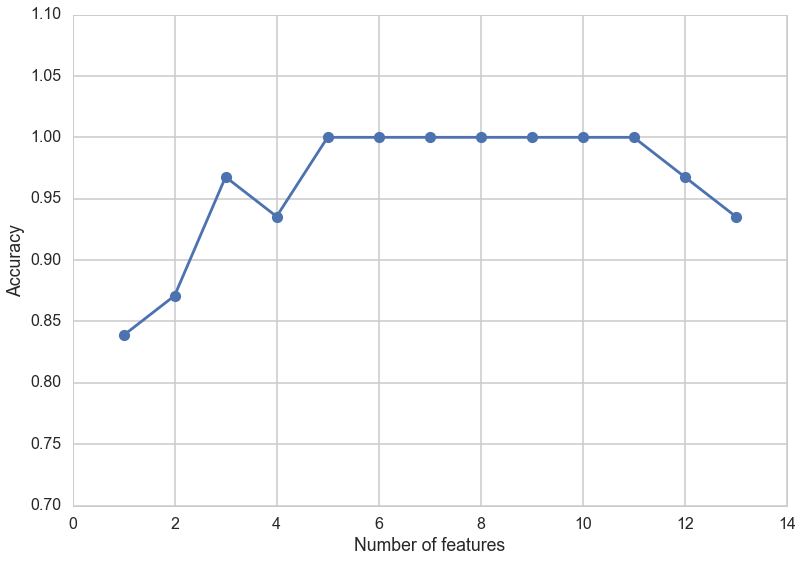

In [149]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [152]:
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


Compare this with original feature set

In [154]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std,y_train))
print('Testing accuracy:', knn.score(X_test_std,y_test))

Training accuracy: 0.983870967742
Testing accuracy: 0.944444444444


Testing is slightly lower, which can be due to a bit of overfitting. 

In [155]:
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5],y_train))
print('Testing accuracy:', knn.score(X_test_std[:, k5],y_test))

Training accuracy: 0.959677419355
Testing accuracy: 0.962962962963


We used the 5 selected features and this time, the gap is smaller and the accuracy of the test set is better.

### Recursive feature elimination (RFE) in sklearn
This only works with classifiers with `coef_` or `feature_importances_` attributes (ex. svm, GLM, RF, etc.)

## Feature importance w/ RF
Feature importance definition:
- **The averaged impurity decrease computed from all decision tress in the forest** (without making any assumptions whether our data is linearly separable or not)

In [163]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=1)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1] # descending sort and get the index of each element in importanes

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]])) # check format characters

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
 4) OD280/OD315 of diluted wines   0.131987
 5) Alcohol                        0.106589
 6) Hue                            0.078243
 7) Total phenols                  0.060718
 8) Alcalinity of ash              0.032033
 9) Malic acid                     0.025400
10) Proanthocyanins                0.022351
11) Magnesium                      0.022078
12) Nonflavanoid phenols           0.014645
13) Ash                            0.013916


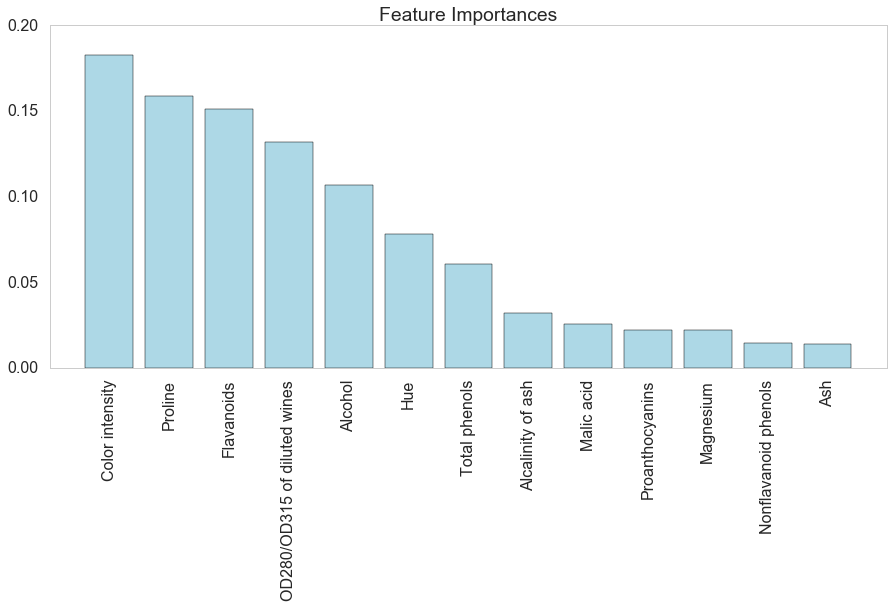

In [177]:
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='lightblue', align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=9b0)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

**Important *gotchas* with RF feature importance**: <span class="mark">if two or more features are highly correlated, one feature may be ranked very highly while the information of the other features may not be fully captured.</span>

If our goal is only increasing predction accuracy, this does not matter.

**Feature importance can be used in pipeline as a feature selector by using a `threshold`**

In [178]:
X_selected = forest.transform(X_train, threshold=0.15) # transform is gonna be deprecated
X_selected.shape

/Users/hongsupshin/anaconda/envs/snakes/lib/python3.5/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


(124, 3)

In [193]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(forest, threshold=0.15)
sfm.fit(X_train, y_train)
sfm.transform(X_train).shape

(124, 3)